In [5]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf 

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
gpus
# len(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [10]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [11]:
!tar -xf lfw.tgz

In [12]:
# move the LFW images to the following respo data/negative

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


In [13]:
# import uuid library to generate unique image names
import uuid

In [125]:
# collect positive and anchor classes
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame=frame[120:120+250,200:200+250,:]

    # collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # create unique file path
        imgname= os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # collect postitive
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname= os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

(250, 250, 3)

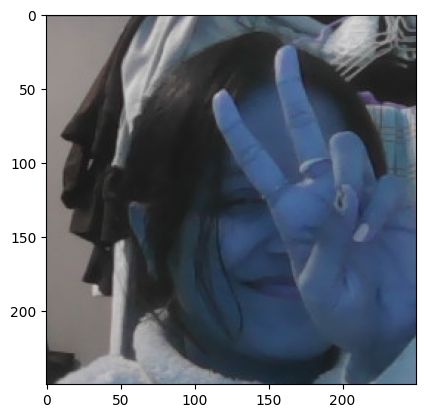

In [126]:
plt.imshow(frame)
frame.shape


In [127]:
# load and preprocess images

# loading image paths
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive =  tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative =  tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [128]:
dir_test =  anchor.as_numpy_iterator()

In [129]:
dir_test.next()

b'data\\anchor\\f1eec48c-af8b-11ee-b1e4-6c9466aabe4f.jpg'

In [130]:
# preprocessing -scale and resize

def preprocess(file_path):

    # read the image from file path
    byte_img = tf.io.read_file(file_path)

    # load in the image
    img = tf.io.decode_jpeg(byte_img)

    # resize the image - preprocessing to (100, 100,3)
    img = tf.image.resize(img, (100,100))

    # scale the image between 0 and 1
    img =  img/255.0
    
    return img

In [131]:
img  =  preprocess('data\\anchor\\012f8539-af8c-11ee-b6e7-6c9466aabe4f.jpg')

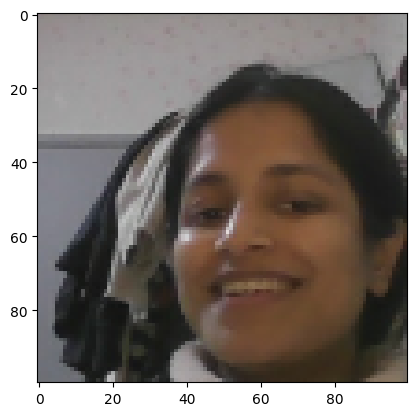

In [132]:
plt.imshow(img)

In [133]:
img.numpy().max()

0.89460784

In [134]:
# create labelled dataset

tf.ones_like([1,1,1,4.345454, 2345.5])

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

In [135]:
# create labelled dataset

# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

# anchor, positive , label(1)
positives =  tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives =  tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# joining pos and neg together
data =  positives.concatenate(negatives)

In [136]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [137]:
samples = data.as_numpy_iterator()

In [138]:
example= samples.next()

In [139]:
example

(b'data\\anchor\\913935ed-af8e-11ee-a4f1-6c9466aabe4f.jpg',
 b'data\\positive\\b919a251-af8e-11ee-9971-6c9466aabe4f.jpg',
 1.0)

In [140]:
# build train and test partition

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [141]:
res = preprocess_twin(*example)

In [142]:
len(res)

3

1.0

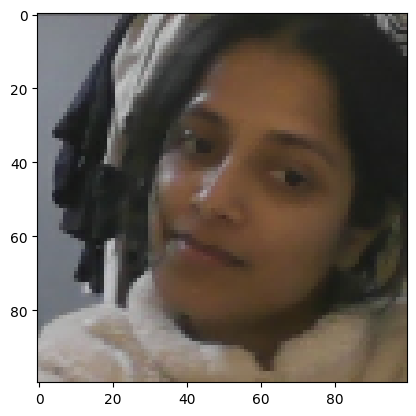

In [143]:
res[0]
plt.imshow(res[1])
res[2]

In [149]:
# build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data =  data.shuffle(buffer_size=1024)

TypeError: in user code:

    File "C:\Users\admin\AppData\Local\Temp\ipykernel_65372\2129839533.py", line 4, in preprocess_twin  *
        return(preprocess(input_img), preprocess(validation_img), label)
    File "C:\Users\admin\AppData\Local\Temp\ipykernel_65372\2622252797.py", line 6, in preprocess  *
        byte_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [ ]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
samples =  data.as_numpy_iterator()

In [168]:
len(samples.next()) 
samp = samples.next()
# this represents anchor img, pos or neg img and a label corresponding to pos or neg

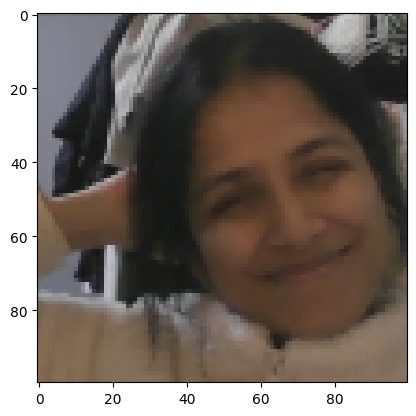

In [169]:
plt.imshow(samp[0])

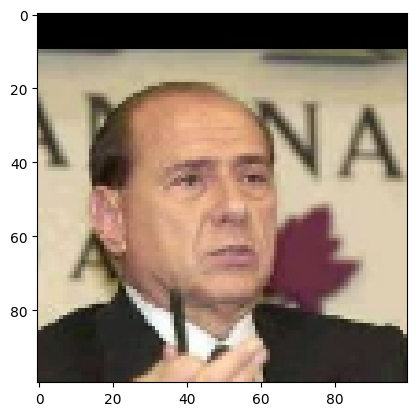

In [170]:
plt.imshow(samp[1])

In [171]:
samp[2]

0.0

In [172]:
round(len(data)*.7)

420

In [173]:
# training partition

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data =  train_data.prefetch(8)

In [174]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [175]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [176]:
train_samples =  train_data.as_numpy_iterator()

In [177]:
train_sample =  train_samples.next()

In [178]:
len(train_sample[0])

16

In [179]:
# testing partition

test_data =  data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [180]:
inp =  Input(shape=(100,100,3), name='input_image')

In [181]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [182]:
# model engineering

# build embedding layer

def make_embedding():
    inp = Input(shape = (100,100,3), name='input_image')

    # first block
    c1 =  Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # second block
    c2 =  Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # 3rd block
    c3 =  Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # final block
    c4 =  Conv2D(256, (4,4), activation='relu')(m3)
    f1 =  Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)   


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [183]:
embedding = make_embedding()

In [184]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [185]:
# build distance layer

# Siamese l1 distance class

class L1Dist(Layer):
    # init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    # magic happens here : similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding -  validation_embedding)
    

In [186]:
l1 = L1Dist()

In [87]:
l1(input_embedding, validation_embedding)

NameError: name 'input_embedding' is not defined

In [187]:
# make siamese mdoel

def make_siamese_model():

    # anchor image input
    input_image = Input(name='input_img', shape=(100,100,3))

    # validation image in the network
    validation_image =  Input(name='validation_img', shape = (100,100,3))

    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances =  siamese_layer(embedding(input_image), embedding(validation_image))

    # classification layer
    classifier =  Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')




In [188]:
siamese_model = make_siamese_model()

In [189]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [190]:
# training

In [191]:
# setup loss and optimiser

binary_cross_loss =  tf.losses.BinaryCrossentropy()

In [192]:
opt =  tf.keras.optimizers.Adam(1e-4)

In [193]:
# establish checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix =  os.path.join(checkpoint_dir, 'ckpt')
checkpoint =  tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [194]:
test_batch = train_data.as_numpy_iterator()

In [195]:
batch_1 =  test_batch.next()

In [196]:
# build train step function

@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        # get anchor and pos/neg image
        x =  batch[:2]
        # get label
        y = batch[2] 

        # forward pass
        yhat =  siamese_model(x, training = True)
        # calculate loss by passing true label and predicted value
        loss = binary_cross_loss(y, yhat)
    
    print(loss)

    # calculate ghradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [197]:
# build training loop

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar =  tf.keras.utils.Progbar(len(data))

    # loop through each batch
    for idx, batch in enumerate(data):
        # run train step here
        
        train_step(batch)
        progbar.update(idx+1)
   
    # save checkpoints
    if epoch % 10 ==0:
        checkpoint.save(file_prefix = checkpoint_prefix)

In [199]:
# train the model

EPOCHS=50


In [200]:
train(train_data, EPOCHS)


 Epoch 1/50

 Epoch 2/50

 Epoch 3/50

 Epoch 4/50

 Epoch 5/50

 Epoch 6/50

 Epoch 7/50

 Epoch 8/50

 Epoch 9/50

 Epoch 10/50

 Epoch 11/50

 Epoch 12/50

 Epoch 13/50

 Epoch 14/50

 Epoch 15/50

 Epoch 16/50

 Epoch 17/50

 Epoch 18/50

 Epoch 19/50

 Epoch 20/50

 Epoch 21/50

 Epoch 22/50

 Epoch 23/50

 Epoch 24/50

 Epoch 25/50

 Epoch 26/50

 Epoch 27/50

 Epoch 28/50

 Epoch 29/50

 Epoch 30/50

 Epoch 31/50

 Epoch 32/50

 Epoch 33/50

 Epoch 34/50

 Epoch 35/50

 Epoch 36/50

 Epoch 37/50

 Epoch 38/50

 Epoch 39/50

 Epoch 40/50

 Epoch 41/50

 Epoch 42/50

 Epoch 43/50

 Epoch 44/50

 Epoch 45/50

 Epoch 46/50

 Epoch 47/50

 Epoch 48/50

 Epoch 49/50

 Epoch 50/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 12s 451ms/step


In [201]:
# evaluate model
# import metric calculations

from tensorflow.keras.metrics import Precision, Recall


In [202]:
# get a batch of test data - going to convert tf dataset into numpy iterator 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [203]:
test_var= test_data.as_numpy_iterator().next()

In [204]:
len(test_var)

3

In [205]:
len(test_var[2])

16

In [206]:
# make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 108ms/step


array([[0.9252474 ],
       [0.03022786],
       [0.03478566],
       [0.00851444],
       [0.24084458],
       [0.9857302 ],
       [0.6539181 ],
       [0.6990503 ],
       [0.04107549],
       [0.9884926 ],
       [0.00458559],
       [0.8793128 ],
       [0.6240323 ],
       [0.14351185],
       [0.02465625],
       [0.520383  ]], dtype=float32)

In [207]:
# post procesing the results
[1 if prediction >0.5 else 0 for prediction in y_hat]

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]

In [208]:
y_true

array([1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

In [209]:
# creating a metric object
# m= Recall()
m= Precision()
# calculating the recall value
m.update_state(y_true, y_hat)
# return result
m.result().numpy()

1.0

In [210]:
# creating a metric object
m= Recall()
# m= Precision()
# calculating the recall value
m.update_state(y_true, y_hat)
# return result
m.result().numpy()

1.0

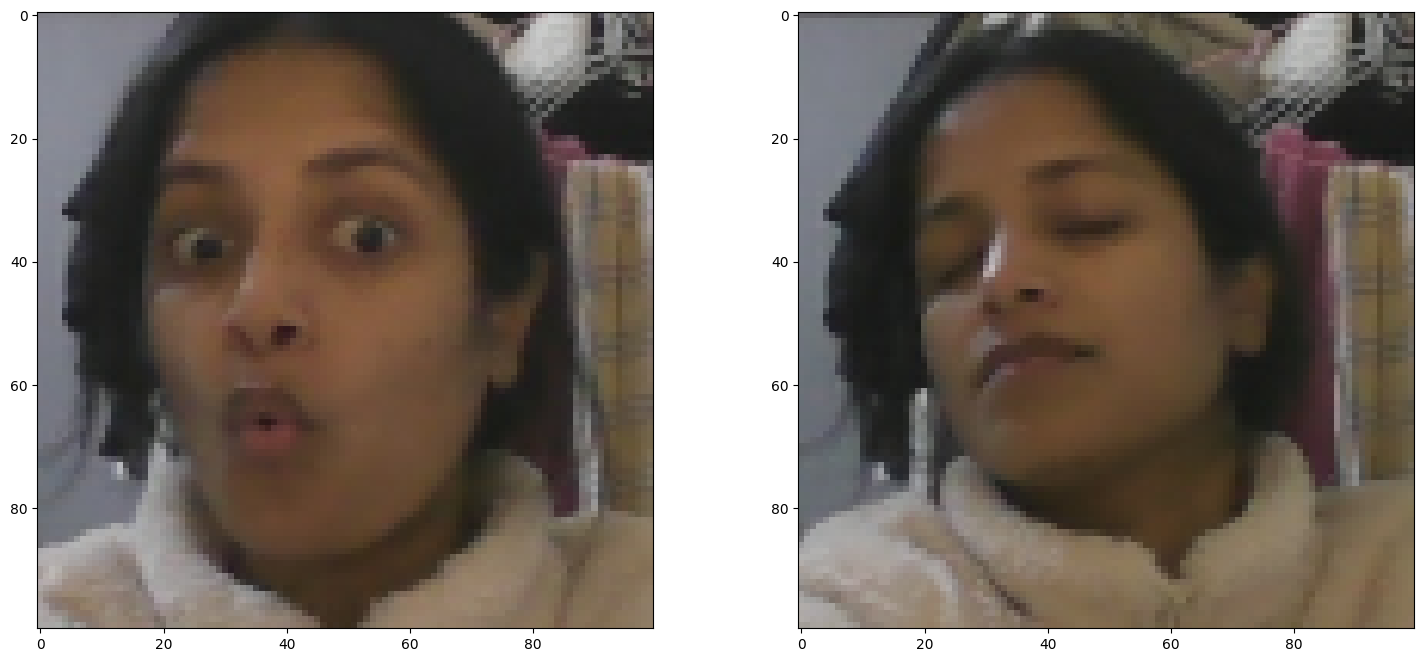

In [211]:
# viz results

# set plot size
plt.figure(figsize=(18,8))

# set first subplot :(row, col, index)
plt.subplot(1,2,1)
plt.imshow(test_input[6])

# set 2nd subplot
plt.subplot(1,2,2)
plt.imshow(test_val[6])

plt.show()

In [212]:
# save weights
siamese_model.save('siamesemodel2.h5')

In [213]:
# reload model

model = tf.keras.models.load_model('siamesemodel2.h5',
          custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [214]:
tf.keras.models.load_model??

Signature:
tf.keras.models.load_model(
    filepath,
    custom_objects=None,
    compile=True,
    options=None,
)
Source:   
@keras_export("keras.models.load_model")
@traceback_utils.filter_traceback
def load_model(filepath, custom_objects=None, compile=True, options=None):
    """Loads a model saved via `model.save()`.

    Usage:

    >>> model = tf.keras.Sequential([
    ...     tf.keras.layers.Dense(5, input_shape=(3,)),
    ...     tf.keras.layers.Softmax()])
    >>> model.save('/tmp/model')
    >>> loaded_model = tf.keras.models.load_model('/tmp/model')
    >>> x = tf.random.uniform((10, 3))
    >>> assert np.allclose(model.predict(x), loaded_model.predict(x))

    Note that the model weights may have different scoped names after being
    loaded. Scoped names include the model/layer names, such as
    `"dense_1/kernel:0"`. It is recommended that you use the layer properties to
    access specific variables, e.g. `model.get_layer("dense_1").kernel`.

    Args:
        filepath:

In [215]:
model.predict([test_input, test_val])

1/1 [==============================] - 0s 104ms/step


array([[0.9252474 ],
       [0.03022786],
       [0.03478566],
       [0.00851444],
       [0.24084458],
       [0.9857302 ],
       [0.6539181 ],
       [0.6990503 ],
       [0.04107549],
       [0.9884926 ],
       [0.00458559],
       [0.8793128 ],
       [0.6240323 ],
       [0.14351185],
       [0.02465625],
       [0.520383  ]], dtype=float32)

In [216]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [217]:
#  real time test

In [218]:
# verificatiob function
def verify(model, detection_threshold, verification_threshold):
    
    # build results array
    results =[]
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img =  preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img =  preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # detection threshold: metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    # verification threshold: proportion of positive predixctions /  total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified
    
    


In [188]:
# opencv realtime verfication

In [219]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]

    cv2.imshow('Verification', frame)

    if cv2.waitKey(10) & 0xFF ==ord('v'):
        # save input image to input_images folder
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # run verification
        results, verified = verify(model, 0.5,0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF ==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 24ms/step
True
1/1 [==============================] - 0s 24ms/step
True
1/1 [==============================] - 0s 20ms/step
True
1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 21ms/step
False


In [220]:
np.sum(np.squeeze(results) >0.6)

10